## importing libraries

In [ ]:
# --- 0. SETUP: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, pearsonr, spearmanr
from collections import Counter
import statsmodels.formula.api as smf # For OLS if needed for ANOVA style output

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## data loading

In [ ]:
file_path = "/content/drive/MyDrive/attiki odos/augmented_accidents_data_final.csv"
try:
    df_full_original = pd.read_csv(file_path, encoding='utf-8')
    print("Original dataset loaded successfully.")
    print(f"Shape: {df_full_original.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    df_full_original = pd.DataFrame() # Ensure df_full_original exists


Original dataset loaded successfully.
Shape: (523, 215)


## definition of target variables

In [ ]:
if not df_full_original.empty:
    # --- 2. DEFINE TARGET VARIABLES ---
    print("\n--- Defining Target Variables ---")


--- Defining Target Variables ---


In [ ]:
if 'ΝΕΚΡΟΙ' in df_full_original.columns:
    df_full_original['accident_severity'] = np.where(df_full_original['ΝΕΚΡΟΙ'] > 0, 1, 0)
    print("Target 'accident_severity' (0: Injury, 1: Death) created from 'ΝΕΚΡΟΙ'.")
    print(df_full_original['accident_severity'].value_counts(normalize=True))
else:
    print("Column 'ΝΕΚΡΟΙ' not found. Cannot create 'accident_severity'.")
    # Fallback or error handling if 'ΝΕΚΡΟΙ' is missing

# 2.2 Accident Duration (Continuous)
if 'duration_minutes' in df_full_original.columns:
    print("\nTarget 'duration_minutes' (Continuous) available.")
    # Optional: Basic cleaning like capping extreme outliers if necessary for Linear Regression
    # For now, we'll use it as is.
else:
    print("Column 'duration_minutes' not found.")

# 2.3 Accident Duration (Binary - 56 min threshold)
if 'duration_minutes' in df_full_original.columns:
    median_duration_56min = 56.0 # As per your ML pipeline
    df_full_original['duration_long_accident_56min'] = np.where(
        df_full_original['duration_minutes'] > median_duration_56min, 1, 0
    )
    print(f"\nTarget 'duration_long_accident_56min' (0: Short, 1: Long > {median_duration_56min}min) created.")
    print(df_full_original['duration_long_accident_56min'].value_counts(normalize=True))
else:
    print("Cannot create 'duration_long_accident_56min' as 'duration_minutes' is missing.")


Target 'accident_severity' (0: Injury, 1: Death) created from 'ΝΕΚΡΟΙ'.
accident_severity
0    0.90631
1    0.09369
Name: proportion, dtype: float64

Target 'duration_minutes' (Continuous) available.

Target 'duration_long_accident_56min' (0: Short, 1: Long > 56.0min) created.
duration_long_accident_56min
0    0.51434
1    0.48566
Name: proportion, dtype: float64


## selecting baseline model features

In [ ]:
# --- 3. SELECT BASELINE FEATURES ---
# Choose a small set of *original*, interpretable features.
# Avoid highly granular or already engineered features for this baseline.
print("\n--- Selecting Baseline Features ---")
baseline_feature_candidates = [
    'ΑΥΤ/ΔΡΟΜΟΣ',       # Road ID (e.g., A, E, K)
    'ΣΗΡΑΓΓΑ',          # Tunnel (Boolean-like, e.g., 'ΕΝΤΟΣ ΣΗΡΑΓΓΑΣ')
    'ΚΑΙΡ._ΣΥΝΘ.',      # Weather Conditions
    'ΣΥΝΘ._ΟΔ.',        # Road Conditions
    'has_ΦΟΡΤΗΓΟ',
    'has_ΤΑΞΙ',
    'has_ΛΕΩΦΟΡΕΙΟ',
    'has_Μ.Ε.'
                        # If not, derive from 'ΗΜΕΡΟΜΗΝΙΑ' or 'DAY_OF_WEEK'
    'has_ΔΙΚΥΚΛΟ',      # Motorcycle involvement
    # Add other simple, original features if desired
]
# Filter to keep only existing columns
baseline_features = [col for col in baseline_feature_candidates if col in df_full_original.columns]
print(f"Selected baseline features: {baseline_features}")



--- Selecting Baseline Features ---
Selected baseline features: ['ΑΥΤ/ΔΡΟΜΟΣ', 'ΣΗΡΑΓΓΑ', 'ΚΑΙΡ._ΣΥΝΘ.', 'ΣΥΝΘ._ΟΔ.', 'has_ΦΟΡΤΗΓΟ', 'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ']


## data splitting

In [ ]:
# --- 4. DATA SPLITTING ---
# Using 'accident_severity' for stratification as it's often the most critical and imbalanced.
# Use the SAME random_state as your ML pipeline for consistency.
print("\n--- Performing Train-Test Split for Baseline Analysis ---")
if 'accident_severity' in df_full_original.columns and baseline_features:
    X_baseline_full = df_full_original[baseline_features]
    # For splitting, we need all target variables aligned.
    # Let's take all potential target columns along for the split, then separate them.
    y_columns_to_split = []
    if 'accident_severity' in df_full_original.columns: y_columns_to_split.append('accident_severity')
    if 'duration_minutes' in df_full_original.columns: y_columns_to_split.append('duration_minutes')
    if 'duration_long_accident_56min' in df_full_original.columns: y_columns_to_split.append('duration_long_accident_56min')

    if not y_columns_to_split:
        print("No target variables available for splitting. Exiting.")
    else:
        Y_baseline_full = df_full_original[y_columns_to_split]

        X_train_baseline, X_temp_baseline, Y_train_baseline, Y_temp_baseline = train_test_split(
            X_baseline_full, Y_baseline_full, test_size=0.4, random_state=42, stratify=df_full_original['accident_severity']
        )
        X_val_baseline, X_test_baseline, Y_val_baseline, Y_test_baseline = train_test_split(
            X_temp_baseline, Y_temp_baseline, test_size=0.5, random_state=42, stratify=Y_temp_baseline['accident_severity']
        )

        # Separate target variables for train, val, test sets
        y_train_severity = Y_train_baseline['accident_severity'] if 'accident_severity' in Y_train_baseline else None
        y_val_severity   = Y_val_baseline['accident_severity'] if 'accident_severity' in Y_val_baseline else None
        y_test_severity  = Y_test_baseline['accident_severity'] if 'accident_severity' in Y_test_baseline else None

        y_train_duration_cont = Y_train_baseline['duration_minutes'] if 'duration_minutes' in Y_train_baseline else None
        y_val_duration_cont   = Y_val_baseline['duration_minutes'] if 'duration_minutes' in Y_val_baseline else None
        y_test_duration_cont  = Y_test_baseline['duration_minutes'] if 'duration_minutes' in Y_test_baseline else None

        y_train_duration_bin  = Y_train_baseline['duration_long_accident_56min'] if 'duration_long_accident_56min' in Y_train_baseline else None
        y_val_duration_bin    = Y_val_baseline['duration_long_accident_56min'] if 'duration_long_accident_56min' in Y_val_baseline else None
        y_test_duration_bin   = Y_test_baseline['duration_long_accident_56min'] if 'duration_long_accident_56min' in Y_test_baseline else None

        print(f"Baseline Training X: {X_train_baseline.shape}, Severity y: {Counter(y_train_severity) if y_train_severity is not None else 'N/A'}")
        print(f"Baseline Validation X: {X_val_baseline.shape}, Severity y: {Counter(y_val_severity) if y_val_severity is not None else 'N/A'}")
        print(f"Baseline Test X: {X_test_baseline.shape}, Severity y: {Counter(y_test_severity) if y_test_severity is not None else 'N/A'}")
else:
    print("Cannot perform split: 'accident_severity' target or baseline features missing.")
    X_train_baseline, X_val_baseline, X_test_baseline = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    # Initialize y variables to None or empty Series to prevent errors later
    y_train_severity, y_val_severity, y_test_severity = None, None, None
    y_train_duration_cont, y_val_duration_cont, y_test_duration_cont = None, None, None
    y_train_duration_bin, y_val_duration_bin, y_test_duration_bin = None, None, None



--- Performing Train-Test Split for Baseline Analysis ---
Baseline Training X: (313, 7), Severity y: Counter({0: 284, 1: 29})
Baseline Validation X: (105, 7), Severity y: Counter({0: 95, 1: 10})
Baseline Test X: (105, 7), Severity y: Counter({0: 95, 1: 10})


## preprocessing

In [ ]:
## prompt: i want to see the amount of missing values for each column
X_train_baseline.isnull().sum()

,0
ΑΥΤ/ΔΡΟΜΟΣ,0
ΣΗΡΑΓΓΑ,0
ΚΑΙΡ._ΣΥΝΘ.,10
ΣΥΝΘ._ΟΔ.,11
has_ΦΟΡΤΗΓΟ,0
has_ΤΑΞΙ,0
has_ΛΕΩΦΟΡΕΙΟ,0


In [ ]:
print("\n--- Diagnosing Unique Values in Categorical Features ---")
if not X_train_baseline.empty and not X_val_baseline.empty and categorical_baseline_features:
   for col in categorical_baseline_features:
    print(f"\nUnique values in '{col}':")
    train_unique = set(X_train_baseline[col].dropna().unique())
    val_unique = set(X_val_baseline[col].dropna().unique())

    print(f"  Train set ({len(train_unique)} unique): {sorted(list(train_unique))}")
    print(f"  Validation set ({len(val_unique)} unique): {sorted(list(val_unique))}")

    unseen_in_val = val_unique - train_unique
    if unseen_in_val:
        print(f"  !!! Categories in Validation set NOT seen in Training set: {sorted(list(unseen_in_val))}")
    else:
        print(f"  All categories in Validation set are present in Training set.")
else:
  print("Skipping unique value diagnosis: Data or categorical features missing.")


--- Diagnosing Unique Values in Categorical Features ---

Unique values in 'ΑΥΤ/ΔΡΟΜΟΣ':
  Train set (10 unique): ['A', 'B', 'E', 'K', 'M', 'N', 'P', 'X', 'Y', 'Z']
  Validation set (10 unique): ['A', 'B', 'E', 'K', 'M', 'N', 'P', 'X', 'Y', 'Z']
  All categories in Validation set are present in Training set.

Unique values in 'ΣΗΡΑΓΓΑ':
  Train set (5 unique): ['no_ΣΗΡΑΓΓΑ', 'ΒΡΙΛΗΣΣΙΩΝ - Α', 'ΚΑΤΕΧΑΚΗ - Κ', 'ΜΕΤΑΜΟΡΦΩΣΗΣ - Ε', 'ΥΜΗΤΤΟΥ Α. - Ρ']
  Validation set (4 unique): ['no_ΣΗΡΑΓΓΑ', 'ΒΡΙΛΗΣΣΙΩΝ - Α', 'ΜΕΤΑΜΟΡΦΩΣΗΣ - Ε', 'ΧΟΛΑΡΓΟΥ - Μ']
  !!! Categories in Validation set NOT seen in Training set: ['ΧΟΛΑΡΓΟΥ - Μ']

Unique values in 'ΚΑΙΡ._ΣΥΝΘ.':
  Train set (4 unique): ['ΒΡΟΧΗ', 'ΙΣΧΥΡΟΙ ΑΝΕΜΟΙ', 'ΚΑΛΟΚΑΙΡΙΑ', 'ΨΙΛΗ ΒΡΟΧΗ']
  Validation set (2 unique): ['ΚΑΛΟΚΑΙΡΙΑ', 'ΨΙΛΗ ΒΡΟΧΗ']
  All categories in Validation set are present in Training set.

Unique values in 'ΣΥΝΘ._ΟΔ.':
  Train set (2 unique): ['ΚΑΝΟΝΙΚΕΣ', 'ΥΓΡΟ - ΒΡΕΓΜΕΝΟ']
  Validation set (2 unique): ['ΚΑΝΟΝΙΚΕΣ', 'ΥΓΡΟ -

In [ ]:
print("\n--- Preprocessing Baseline Features (Imputation & OHE) ---")
if not X_train_baseline.empty:
    numerical_baseline_features = X_train_baseline.select_dtypes(include=np.number).columns.tolist()
    categorical_baseline_features = X_train_baseline.select_dtypes(include='object').columns.tolist()
    # Identify explicit passthrough features by subtracting numerical and categorical from all columns
    passthrough_features = [col for col in X_train_baseline.columns if col not in numerical_baseline_features and col not in categorical_baseline_features]


    # Create transformers
    # Simpler imputation for direct statistical tests if needed on X_train_baseline itself
    X_train_baseline_imputed_for_tests = X_train_baseline.copy()
    for col in numerical_baseline_features:
        X_train_baseline_imputed_for_tests[col].fillna(X_train_baseline[col].median(), inplace=True)
    for col in categorical_baseline_features:
        # Handle potential empty mode if all values are NaN, though fillna('Unknown') is robust
        mode_val = X_train_baseline[col].mode()
        fill_value = mode_val[0] if not mode_val.empty else 'Unknown'
        X_train_baseline_imputed_for_tests[col].fillna(fill_value, inplace=True)


    # Preprocessor for baseline *models* (Logistic/Linear Regression)
    # Ensure that the transformers list correctly handles all columns.
    # Explicitly name 'passthrough' columns in the ColumnTransformer definition
    # and ensure categorical transformer is correctly defined within a Pipeline.
    model_preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_baseline_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_baseline_features),
            ('passthrough', 'passthrough', passthrough_features) # Explicitly define passthrough columns
        ],
        remainder='drop' # Explicitly drop any columns not listed in transformers
    )

    # Fit on training data for models
    # This step learns the vocabulary for OneHotEncoder and the imputation values
    X_train_baseline_processed = model_preprocessor.fit_transform(X_train_baseline)

    # Get feature names *after* fitting on the training data
    # This method should now correctly reflect the number of output columns
    # based on the fitted transformers (including OHE vocabulary and passthrough).
    try:
        processed_feature_names = model_preprocessor.get_feature_names_out()
    except AttributeError:
        print("Warning: get_feature_names_out() not available. Please consider upgrading scikit-learn (>=0.23) for reliable feature naming.")
        # Fallback for older sklearn - manual reconstruction (less reliable for OHE)
        # If this happens, you might need to manually get category names from the fitted OHE
        # This is complex, so relying on get_feature_names_out is strongly recommended.
        processed_feature_names = [] # Placeholder, will likely lead to errors without get_feature_names_out

    # Transform validation and test data
    # The transform method will now use the vocabulary learned from X_train_baseline
    # and handle unseen categories in X_val/X_test as all zeros due to handle_unknown='ignore'.
    # The number of output columns should match X_train_baseline_processed.shape[1].
    X_val_baseline_processed   = model_preprocessor.transform(X_val_baseline)
    X_test_baseline_processed  = model_preprocessor.transform(X_test_baseline)


    # Create DataFrames immediately to check structure
    # Use the feature names obtained *from the fitted* preprocessor
    # The number of columns in the transformed arrays should match the number of feature names.
    try:
        # Ensure the number of feature names matches the number of columns in the transformed arrays
        if 'processed_feature_names' in locals() and len(processed_feature_names) == X_train_baseline_processed.shape[1]:
             X_train_baseline_processed_df = pd.DataFrame(X_train_baseline_processed, columns=processed_feature_names, index=X_train_baseline.index)
             X_val_baseline_processed_df   = pd.DataFrame(X_val_baseline_processed, columns=processed_feature_names, index=X_val_baseline.index)
             X_test_baseline_processed_df  = pd.DataFrame(X_test_baseline_processed, columns=processed_feature_names, index=X_test_baseline.index)

             print(f"Processed baseline training X for models: {X_train_baseline_processed_df.shape}")
             print(f"Processed baseline validation X for models: {X_val_baseline_processed_df.shape}")
             print(f"Processed baseline test X for models: {X_test_baseline_processed_df.shape}")
        else:
            print("Error: Mismatch between generated feature names and transformed data columns.")
            print(f"Number of feature names: {len(processed_feature_names) if 'processed_feature_names' in locals() else 'N/A'}")
            print(f"Number of columns in transformed training data: {X_train_baseline_processed.shape[1]}")
            print(f"Number of columns in transformed validation data: {X_val_baseline_processed.shape[1]}")
            print(f"Number of columns in transformed test data: {X_test_baseline_processed.shape[1]}")
            # If the counts don't match here, the issue might be deeper or a library bug.
            # Revert to numpy arrays if DataFrame creation fails, but this will affect downstream steps.
            # As a last resort, if names are critical and this fails, you might need
            # to manually build column names from the fitted OHE categories + passthrough names.


    except ValueError as e:
         print(f"Error creating DataFrame after preprocessing: {e}")
         print("This likely indicates a mismatch in the number of columns produced by transform vs. the number of feature names.")
         if 'processed_feature_names' in locals():
            print(f"Expected feature names count: {len(processed_feature_names)}")
         print(f"Actual columns in transformed data (train): {X_train_baseline_processed.shape[1]}")
         print(f"Actual columns in transformed data (val): {X_val_baseline_processed.shape[1]}")
         print(f"Actual columns in transformed data (test): {X_test_baseline_processed.shape[1]}")
         # Re-raise the error to stop execution and allow inspection if needed
         raise

else:
    print("X_train_baseline is empty. Skipping preprocessing.")
    X_train_baseline_imputed_for_tests = pd.DataFrame()
    X_train_baseline_processed_df = pd.DataFrame()
    X_val_baseline_processed_df = pd.DataFrame()
    X_test_baseline_processed_df = pd.DataFrame()



--- Preprocessing Baseline Features (Imputation & OHE) ---
Processed baseline training X for models: (313, 24)
Processed baseline validation X for models: (105, 24)
Processed baseline test X for models: (105, 24)


<ipython-input-20-031bde1e5776>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_baseline_imputed_for_tests[col].fillna(fill_value, inplace=True)


In [ ]:
print("\n--- Preprocessing Baseline Features (Imputation & OHE) ---")
if not X_train_baseline.empty:
    numerical_baseline_features = X_train_baseline.select_dtypes(include=np.number).columns.tolist()
    categorical_baseline_features = X_train_baseline.select_dtypes(include='object').columns.tolist()

    # Create transformers
    # For statistical tests, we often work with original data + simple imputation.
    # For baseline *models*, more thorough preprocessing is needed.
    # Let's create a preprocessor for the models.

    # Simpler imputation for direct statistical tests if needed on X_train_baseline itself
    X_train_baseline_imputed_for_tests = X_train_baseline.copy()
    for col in numerical_baseline_features:
        X_train_baseline_imputed_for_tests[col].fillna(X_train_baseline[col].median(), inplace=True)
    for col in categorical_baseline_features:
        X_train_baseline_imputed_for_tests[col].fillna(X_train_baseline[col].mode()[0] if not X_train_baseline[col].mode().empty else 'Unknown', inplace=True)


    # Preprocessor for baseline *models* (Logistic/Linear Regression)
    num_transformer_model = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
        # ('scaler', StandardScaler()) # Optional for baseline models
    ])
    cat_transformer_model = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Or 'constant', fill_value='Unknown'
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    model_preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer_model, numerical_baseline_features),
            ('cat', cat_transformer_model, categorical_baseline_features)
        ], remainder='passthrough' # In case some boolean features were not caught
    )

    # Fit on training data for models
    X_train_baseline_processed = model_preprocessor.fit_transform(X_train_baseline)
    X_val_baseline_processed   = model_preprocessor.transform(X_val_baseline)
    X_test_baseline_processed  = model_preprocessor.transform(X_test_baseline)

    # Get feature names for processed data
    try:
        processed_feature_names = model_preprocessor.get_feature_names_out()
    except AttributeError: # Older sklearn
          # Manual reconstruction (simplified)
        processed_feature_names = []
        if 'num' in model_preprocessor.named_transformers_:
            processed_feature_names.extend(model_preprocessor.named_transformers_['num'].feature_names_in_)
        if 'cat' in model_preprocessor.named_transformers_:
              # This is more complex, get_feature_names_out is better
            ohe = model_preprocessor.named_transformers_['cat'].named_steps['onehot']
            processed_feature_names.extend(ohe.get_feature_names_out(categorical_baseline_features))

    X_train_baseline_processed_df = pd.DataFrame(X_train_baseline_processed, columns=processed_feature_names, index=X_train_baseline.index)
    X_val_baseline_processed_df   = pd.DataFrame(X_val_baseline_processed, columns=processed_feature_names, index=X_val_baseline.index)
    X_test_baseline_processed_df  = pd.DataFrame(X_test_baseline_processed, columns=processed_feature_names, index=X_test_baseline.index)

    print(f"Processed baseline training X for models: {X_train_baseline_processed_df.shape}")
else:
    print("X_train_baseline is empty. Skipping preprocessing.")
    X_train_baseline_imputed_for_tests = pd.DataFrame()
    X_train_baseline_processed_df = pd.DataFrame()
    X_val_baseline_processed_df = pd.DataFrame()
    X_test_baseline_processed_df = pd.DataFrame()



--- Preprocessing Baseline Features (Imputation & OHE) ---
Processed baseline training X for models: (313, 24)


<ipython-input-21-344e5440baba>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_baseline_imputed_for_tests[col].fillna(X_train_baseline[col].mode()[0] if not X_train_baseline[col].mode().empty else 'Unknown', inplace=True)


## statistical analysis for factors associated with accident severity



--- 6.2.5.1 Statistical Analysis of Factors Associated with Accident Severity ---
Methodology: Chi-squared for categorical vs. severity, T-test for numerical vs. severity.

--- ΑΥΤ/ΔΡΟΜΟΣ vs. Accident Severity ---


accident_severity,0,1
ΑΥΤ/ΔΡΟΜΟΣ,,
A,98,7
B,9,1
E,111,15
K,22,1
M,18,1
N,4,0
P,8,2
X,4,1
Y,5,0


Chi-squared test: chi2=6.28, p-value=0.7112, df=9
Fatality Rate per category:


,Fatality Rate
ΑΥΤ/ΔΡΟΜΟΣ,
P,0.200000
X,0.200000
Z,0.166667
E,0.119048
B,0.100000
A,0.066667
M,0.052632
K,0.043478
N,0.000000


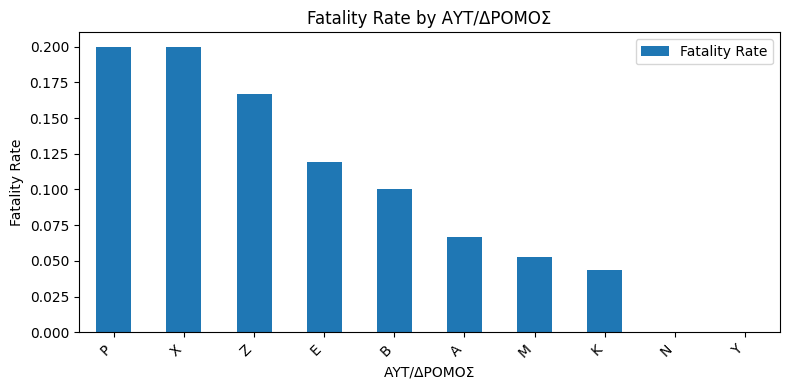


--- ΣΗΡΑΓΓΑ vs. Accident Severity ---


accident_severity,0,1
ΣΗΡΑΓΓΑ,,
no_ΣΗΡΑΓΓΑ,280,28
ΒΡΙΛΗΣΣΙΩΝ - Α,1,0
ΚΑΤΕΧΑΚΗ - Κ,1,0
ΜΕΤΑΜΟΡΦΩΣΗΣ - Ε,1,0
ΥΜΗΤΤΟΥ Α. - Ρ,1,1


Chi-squared test: chi2=4.27, p-value=0.3713, df=4
Fatality Rate per category:


,Fatality Rate
ΣΗΡΑΓΓΑ,
ΥΜΗΤΤΟΥ Α. - Ρ,0.500000
no_ΣΗΡΑΓΓΑ,0.090909
ΒΡΙΛΗΣΣΙΩΝ - Α,0.000000
ΚΑΤΕΧΑΚΗ - Κ,0.000000
ΜΕΤΑΜΟΡΦΩΣΗΣ - Ε,0.000000


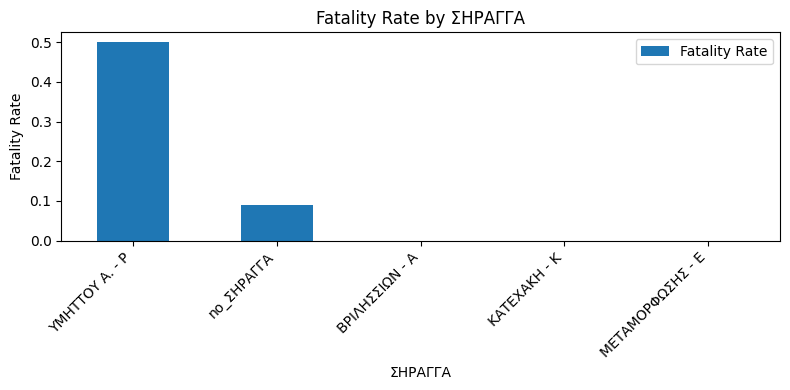


--- ΚΑΙΡ._ΣΥΝΘ. vs. Accident Severity ---


accident_severity,0,1
ΚΑΙΡ._ΣΥΝΘ.,,
ΒΡΟΧΗ,6,0
ΙΣΧΥΡΟΙ ΑΝΕΜΟΙ,1,0
ΚΑΛΟΚΑΙΡΙΑ,268,29
ΨΙΛΗ ΒΡΟΧΗ,9,0


Chi-squared test: chi2=1.72, p-value=0.6321, df=3
Fatality Rate per category:


,Fatality Rate
ΚΑΙΡ._ΣΥΝΘ.,
ΚΑΛΟΚΑΙΡΙΑ,0.097643
ΒΡΟΧΗ,0.000000
ΙΣΧΥΡΟΙ ΑΝΕΜΟΙ,0.000000
ΨΙΛΗ ΒΡΟΧΗ,0.000000


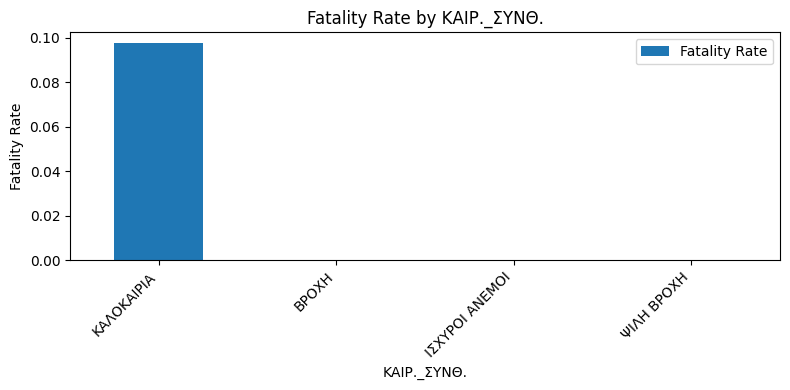


--- ΣΥΝΘ._ΟΔ. vs. Accident Severity ---


accident_severity,0,1
ΣΥΝΘ._ΟΔ.,,
ΚΑΝΟΝΙΚΕΣ,259,29
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ,25,0


Chi-squared test: chi2=1.71, p-value=0.1915, df=1
Fatality Rate per category:


,Fatality Rate
ΣΥΝΘ._ΟΔ.,
ΚΑΝΟΝΙΚΕΣ,0.100694
ΥΓΡΟ - ΒΡΕΓΜΕΝΟ,0.000000


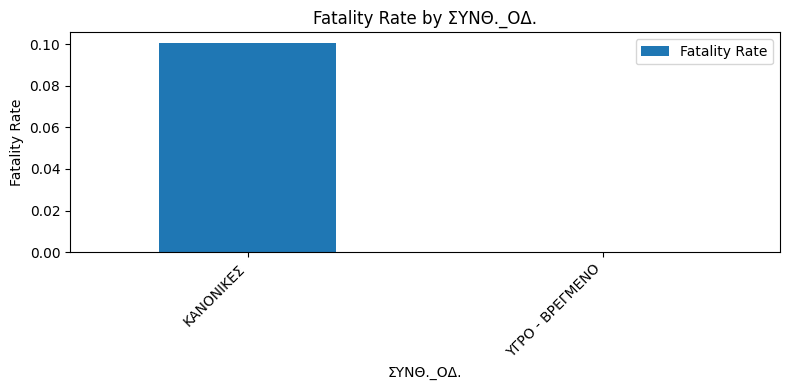

In [ ]:
print("\n\n--- 6.2.5.1 Statistical Analysis of Factors Associated with Accident Severity ---")
if y_train_severity is not None and not X_train_baseline_imputed_for_tests.empty:
    print("Methodology: Chi-squared for categorical vs. severity, T-test for numerical vs. severity.")

    # Categorical features vs. Severity
    for col in categorical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns:
            print(f"\n--- {col} vs. Accident Severity ---")
            contingency_table = pd.crosstab(X_train_baseline_imputed_for_tests[col], y_train_severity)
            if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                print("Skipping Chi-squared: Contingency table too small.")
                continue

            display(contingency_table)
            try:
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                print(f"Chi-squared test: chi2={chi2:.2f}, p-value={p:.4f}, df={dof}")
                if p < 0.05:
                    print(f"'{col}' shows a statistically significant association with accident severity (p < 0.05).")

                # Fatality rate per category
                fatality_rate = contingency_table.apply(lambda r: r[1] / (r[0] + r[1]) if (r[0] + r[1]) > 0 else 0, axis=1)
                fatality_rate_df = fatality_rate.sort_values(ascending=False).to_frame(name='Fatality Rate')
                print("Fatality Rate per category:")
                display(fatality_rate_df)

                # Visualization
                plt.figure(figsize=(8, 4))
                fatality_rate_df.plot(kind='bar', ax=plt.gca())
                plt.title(f"Fatality Rate by {col}")
                plt.ylabel("Fatality Rate")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout()
                plt.show()

            except ValueError as e:
                print(f"Could not perform Chi-squared for {col}: {e}")


    # Numerical features vs. Severity
    for col in numerical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns and y_train_severity is not None:
            print(f"\n--- {col} vs. Accident Severity ---")
            group_injury = X_train_baseline_imputed_for_tests[y_train_severity == 0][col].dropna()
            group_death  = X_train_baseline_imputed_for_tests[y_train_severity == 1][col].dropna()

            if len(group_injury) < 2 or len(group_death) < 2:
                print(f"Skipping T-test for {col}: Not enough data in one or both groups.")
                continue

            try:
                t_stat, p_val = ttest_ind(group_injury, group_death, equal_var=False) # Welch's t-test
                print(f"T-test for {col}: t-statistic={t_stat:.2f}, p-value={p_val:.4f}")
                if p_val < 0.05:
                    print(f"'{col}' shows a statistically significant difference between severity groups (p < 0.05).")
                    print(f"Mean for Injury group: {group_injury.mean():.2f}, Mean for Death group: {group_death.mean():.2f}")

                # Visualization
                plt.figure(figsize=(6, 4))
                sns.boxplot(x=y_train_severity, y=X_train_baseline_imputed_for_tests[col])
                plt.title(f"{col} by Accident Severity")
                plt.xticks([0,1], ['Injury', 'Death'])
                plt.show()

            except Exception as e:
                print(f"Could not perform T-test for {col}: {e}")
else:
    print("Skipping severity statistical analysis: Required data missing.")


## baseline model for severity prediction

In [ ]:
print("\n\n--- 6.2.5.2 Baseline Model for Severity Prediction ---")
if y_test_severity is not None and not X_train_baseline_processed_df.empty and not X_test_baseline_processed_df.empty:
    print("Model: Logistic Regression with selected original features.")
    baseline_severity_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)

    try:
        baseline_severity_model.fit(X_train_baseline_processed_df, y_train_severity)
        y_pred_severity_baseline = baseline_severity_model.predict(X_test_baseline_processed_df)
        y_proba_severity_baseline = baseline_severity_model.predict_proba(X_test_baseline_processed_df)[:, 1]

        print("\nBaseline Severity Model - Test Set Performance:")
        print(classification_report(y_test_severity, y_pred_severity_baseline, target_names=['Injury (0)', 'Death (1)'], zero_division=0))
        print("Confusion Matrix (Test Set):")
        print(confusion_matrix(y_test_severity, y_pred_severity_baseline))

        roc_auc_sev_base = roc_auc_score(y_test_severity, y_proba_severity_baseline)
        precision_sev_base, recall_sev_base, _ = precision_recall_curve(y_test_severity, y_proba_severity_baseline, pos_label=1)
        pr_auc_sev_base = auc(recall_sev_base, precision_sev_base)

        print(f"ROC AUC: {roc_auc_sev_base:.4f}")
        print(f"PR AUC (for Death class): {pr_auc_sev_base:.4f}")
        f1_death_base = f1_score(y_test_severity, y_pred_severity_baseline, pos_label=1, zero_division=0)
        print(f"F1 Score (Death): {f1_death_base:.4f}")

    except Exception as e:
        print(f"Error training/evaluating baseline severity model: {e}")
else:
    print("Skipping baseline severity model: Required data missing.")




--- 6.2.5.2 Baseline Model for Severity Prediction ---
Model: Logistic Regression with selected original features.

Baseline Severity Model - Test Set Performance:
              precision    recall  f1-score   support

  Injury (0)       0.87      0.42      0.57        95
   Death (1)       0.07      0.40      0.12        10

    accuracy                           0.42       105
   macro avg       0.47      0.41      0.34       105
weighted avg       0.79      0.42      0.52       105

Confusion Matrix (Test Set):
[[40 55]
 [ 6  4]]
ROC AUC: 0.4489
PR AUC (for Death class): 0.1734
F1 Score (Death): 0.1159


## statistical analysis for factors asssociated with accident duration

In [ ]:
print("\n\n--- 6.2.5.3 Statistical Analysis of Factors Associated with Accident Duration ---")
if y_train_duration_cont is not None and y_train_duration_bin is not None and not X_train_baseline_imputed_for_tests.empty:
    print("Methodology: Correlation for numerical vs. continuous duration; ANOVA for categorical vs. continuous duration; Chi-squared/T-test for vs. binary duration.")

    # A. Continuous Duration (duration_minutes)
    print("\n--- A. Factors vs. Continuous Duration (duration_minutes) ---")
    # Numerical features vs. Continuous Duration (Correlation)
    for col in numerical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns and y_train_duration_cont is not None:
            # Align data and drop NaNs for correlation
            temp_df_corr = pd.concat([X_train_baseline_imputed_for_tests[col], y_train_duration_cont], axis=1).dropna()
            if len(temp_df_corr) > 2: # Need at least 2 pairs for correlation
                pear_corr, p_pear = pearsonr(temp_df_corr[col], temp_df_corr['duration_minutes'])
                spear_corr, p_spear = spearmanr(temp_df_corr[col], temp_df_corr['duration_minutes'])
                print(f"{col}: Pearson r={pear_corr:.2f} (p={p_pear:.3f}), Spearman rho={spear_corr:.2f} (p={p_spear:.3f})")
                if p_pear < 0.05 or p_spear < 0.05:
                     print(f"'{col}' shows a statistically significant correlation with continuous duration.")
            else:
                print(f"Skipping correlation for {col}: Not enough non-NaN pairs.")

    # Categorical features vs. Continuous Duration (ANOVA)
    for col in categorical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns and y_train_duration_cont is not None:
            print(f"\n--- {col} vs. Continuous Duration (ANOVA) ---")
            groups = [y_train_duration_cont[X_train_baseline_imputed_for_tests[col] == cat].dropna() for cat in X_train_baseline_imputed_for_tests[col].unique()]
            groups = [g for g in groups if len(g) >= 2] # ANOVA needs at least 2 samples per group
            if len(groups) >= 2: # ANOVA needs at least 2 groups
                try:
                    f_stat, p_val = f_oneway(*groups)
                    print(f"ANOVA for {col}: F-statistic={f_stat:.2f}, p-value={p_val:.4f}")
                    if p_val < 0.05:
                        print(f"'{col}' shows a statistically significant difference in mean duration across its categories (p < 0.05).")
                except Exception as e:
                    print(f"Could not perform ANOVA for {col}: {e}")
            else:
                print(f"Skipping ANOVA for {col}: Not enough groups or samples per group.")

    # B. Binary Duration (duration_long_accident_56min)
    print("\n--- B. Factors vs. Binary Duration (duration_long_accident_56min) ---")
    # Categorical features vs. Binary Duration
    for col in categorical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns and y_train_duration_bin is not None:
            # (Similar to severity analysis with Chi-squared)
            contingency_table_dur = pd.crosstab(X_train_baseline_imputed_for_tests[col], y_train_duration_bin)
            if contingency_table_dur.empty or contingency_table_dur.shape[0] < 2 or contingency_table_dur.shape[1] < 2:
                continue
            chi2_dur, p_dur, dof_dur, _ = chi2_contingency(contingency_table_dur)
            print(f"{col} vs. Binary Duration: Chi2={chi2_dur:.2f}, p={p_dur:.4f}")
            if p_dur < 0.05: print(f"  Significant association.")


    # Numerical features vs. Binary Duration
    for col in numerical_baseline_features:
        if col in X_train_baseline_imputed_for_tests.columns and y_train_duration_bin is not None:
            # (Similar to severity analysis with T-test)
            group0_dur = X_train_baseline_imputed_for_tests[y_train_duration_bin == 0][col].dropna()
            group1_dur = X_train_baseline_imputed_for_tests[y_train_duration_bin == 1][col].dropna()
            if len(group0_dur) >=2 and len(group1_dur) >=2:
                t_stat_dur, p_val_dur = ttest_ind(group0_dur, group1_dur, equal_var=False)
                print(f"{col} vs. Binary Duration: T-stat={t_stat_dur:.2f}, p={p_val_dur:.4f}")
                if p_val_dur < 0.05: print(f"  Significant difference.")
else:
    print("Skipping duration statistical analysis: Required data missing.")





--- 6.2.5.3 Statistical Analysis of Factors Associated with Accident Duration ---
Methodology: Correlation for numerical vs. continuous duration; ANOVA for categorical vs. continuous duration; Chi-squared/T-test for vs. binary duration.

--- A. Factors vs. Continuous Duration (duration_minutes) ---
num_involved_vehicles: Pearson r=0.11 (p=0.044), Spearman rho=0.18 (p=0.002)
'num_involved_vehicles' shows a statistically significant correlation with continuous duration.
is_weekend: Pearson r=0.06 (p=0.266), Spearman rho=0.07 (p=0.237)

--- ΑΥΤ/ΔΡΟΜΟΣ vs. Continuous Duration (ANOVA) ---
ANOVA for ΑΥΤ/ΔΡΟΜΟΣ: F-statistic=1.16, p-value=0.3235

--- ΣΗΡΑΓΓΑ vs. Continuous Duration (ANOVA) ---
ANOVA for ΣΗΡΑΓΓΑ: F-statistic=1.39, p-value=0.2397

--- ΚΑΙΡ._ΣΥΝΘ. vs. Continuous Duration (ANOVA) ---
ANOVA for ΚΑΙΡ._ΣΥΝΘ.: F-statistic=0.08, p-value=0.9235

--- ΣΥΝΘ._ΟΔ. vs. Continuous Duration (ANOVA) ---
ANOVA for ΣΥΝΘ._ΟΔ.: F-statistic=0.08, p-value=0.7719

--- effective_lighting_condition vs.

## baseline models for duration prediction

In [ ]:
print("\n\n--- 6.2.5.4 Baseline Models for Duration Prediction ---")
# A. Continuous Duration (duration_minutes) - Linear Regression
if y_test_duration_cont is not None and not X_train_baseline_processed_df.empty and not X_test_baseline_processed_df.empty:
    print("\n--- A. Baseline for Continuous Duration (Linear Regression) ---")
    baseline_duration_cont_model = LinearRegression()
    try:
        # Need to drop NaNs from y_train_duration_cont and align X_train_baseline_processed_df
        y_train_cont_dropna = y_train_duration_cont.dropna()
        X_train_cont_aligned = X_train_baseline_processed_df.loc[y_train_cont_dropna.index]

        baseline_duration_cont_model.fit(X_train_cont_aligned, y_train_cont_dropna)

        # Align y_test_duration_cont with X_test_baseline_processed_df for prediction
        y_test_cont_dropna = y_test_duration_cont.dropna()
        X_test_cont_aligned = X_test_baseline_processed_df.loc[y_test_cont_dropna.index]
        y_true_cont_aligned = y_test_cont_dropna # True values for comparison

        y_pred_duration_cont_base = baseline_duration_cont_model.predict(X_test_cont_aligned)

        print("Linear Regression - Test Set Performance:")
        print(f"R-squared: {r2_score(y_true_cont_aligned, y_pred_duration_cont_base):.4f}")
        print(f"MAE: {mean_absolute_error(y_true_cont_aligned, y_pred_duration_cont_base):.2f} minutes")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_true_cont_aligned, y_pred_duration_cont_base)):.2f} minutes")
    except Exception as e:
        print(f"Error training/evaluating baseline continuous duration model: {e}")
else:
    print("Skipping baseline continuous duration model: Required data missing.")

# B. Binary Duration (duration_long_accident_56min) - Logistic Regression
if y_test_duration_bin is not None and not X_train_baseline_processed_df.empty and not X_test_baseline_processed_df.empty:
    print("\n--- B. Baseline for Binary Duration (Logistic Regression) ---")
    baseline_duration_bin_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)
    try:
        baseline_duration_bin_model.fit(X_train_baseline_processed_df, y_train_duration_bin)
        y_pred_duration_bin_base = baseline_duration_bin_model.predict(X_test_baseline_processed_df)
        y_proba_duration_bin_base = baseline_duration_bin_model.predict_proba(X_test_baseline_processed_df)[:, 1]

        print("Logistic Regression (Binary Duration) - Test Set Performance:")
        print(classification_report(y_test_duration_bin, y_pred_duration_bin_base, target_names=['Short (0)', 'Long (1)'], zero_division=0))
        print("Confusion Matrix (Test Set):")
        print(confusion_matrix(y_test_duration_bin, y_pred_duration_bin_base))

        roc_auc_dur_bin_base = roc_auc_score(y_test_duration_bin, y_proba_duration_bin_base)
        precision_dur_bin_base, recall_dur_bin_base, _ = precision_recall_curve(y_test_duration_bin, y_proba_duration_bin_base, pos_label=1)
        pr_auc_dur_bin_base = auc(recall_dur_bin_base, precision_dur_bin_base)

        print(f"ROC AUC: {roc_auc_dur_bin_base:.4f}")
        print(f"PR AUC (for Long class): {pr_auc_dur_bin_base:.4f}")
        f1_long_dur_base = f1_score(y_test_duration_bin, y_pred_duration_bin_base, pos_label=1, zero_division=0)
        print(f"F1 Score (Long): {f1_long_dur_base:.4f}")
    except Exception as e:
        print(f"Error training/evaluating baseline binary duration model: {e}")
else:
    print("Skipping baseline binary duration model: Required data missing.")





--- 6.2.5.4 Baseline Models for Duration Prediction ---

--- A. Baseline for Continuous Duration (Linear Regression) ---
Linear Regression - Test Set Performance:
R-squared: 0.1645
MAE: 19.31 minutes
RMSE: 34.49 minutes

--- B. Baseline for Binary Duration (Logistic Regression) ---
Logistic Regression (Binary Duration) - Test Set Performance:
              precision    recall  f1-score   support

   Short (0)       0.69      0.73      0.71        48
    Long (1)       0.76      0.72      0.74        57

    accuracy                           0.72       105
   macro avg       0.72      0.72      0.72       105
weighted avg       0.73      0.72      0.72       105

Confusion Matrix (Test Set):
[[35 13]
 [16 41]]
ROC AUC: 0.7920
PR AUC (for Long class): 0.7865
F1 Score (Long): 0.7387
